# Handwritten Digit Recognition
## Deep Learning (18CSE484T) Group Project

### Group Members:

- Bhavesh Laddagiri (RA1911026030032)
- Akshaj Vishwanathan (RA1911026030003)
- Hardik Gupta (RA1911026030027)

In [1]:
from PIL import Image
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms

## Dataset

In [2]:
# Image transformations
preprocess = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor()
])

In [3]:
# Download train and test data
train_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=preprocess,
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=preprocess,
)

In [15]:
train_data[2][0].shape

torch.Size([1, 28, 28])

In [16]:
batch_size = 96

# Create data loaders.
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size)

for X, y in train_loader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

Shape of X [N, C, H, W]:  torch.Size([96, 1, 28, 28])
Shape of y:  torch.Size([96]) torch.int64


## Build Model

In [17]:
# Get cpu or gpu device automatically for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [18]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(1, 32, 3),
                                   nn.ReLU(inplace=True),
                                   nn.MaxPool2d(2))
        
        self.conv2 = nn.Sequential(nn.Conv2d(32, 16, 3),
                                   nn.ReLU(inplace=True),
                                   nn.MaxPool2d(2))
        
        # print(self.calculate_size())
        self.fc = nn.Sequential(nn.Linear(self.calculate_size(), 256),
                                nn.Linear(256, 10))
    
    def forward(self, x):
        # x shape should be [batch_size, channels, height, width]
        x = self.conv1(x)
        x = self.conv2(x)
        
        # reshape the output to flat row vectors of length batch_size
        x = x.view(x.size(0), -1)
        x = self.fc(x)
            
        return x
        
    def calculate_size(self):
        '''Utility to calculate the output size 
        from the convolution layers'''
        x = torch.randn((1, 1, 28, 28))
        x = self.conv1(x)
        x = self.conv2(x)
        size = x.flatten().shape[0]
        return size

model = CNNModel().to(device)
print(model)

CNNModel(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=400, out_features=256, bias=True)
    (1): Linear(in_features=256, out_features=10, bias=True)
  )
)


In [19]:
out = model(train_data[0][0].unsqueeze(0).to(device))
out

tensor([[ 0.0638,  0.0525, -0.0563,  0.0391, -0.0057, -0.0267,  0.0323, -0.1234,
         -0.0034,  0.0641]], device='cuda:0', grad_fn=<AddmmBackward0>)

## Train Model

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-3)

In [20]:
def train(dataloader, model, criterion, optimizer):
    size = len(dataloader.dataset)
    
    # set the model to train mode
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Move the inputs to device
        X, y = X.to(device), y.to(device)

        # Model forward pass
        pred = model(X)
        
        # Compute the loss
        loss = criterion(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"Train Loss: {loss:>7f}  [{current:>5d}/{size:>5d}]\r", end="")
    print()

In [21]:
def test(dataloader, model, criterion):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    
    # set the model to eval mode
    model.eval()
    
    test_loss, correct = 0, 0
    
    with torch.no_grad():
        for X, y in dataloader:
            # Move the inputs to device
            X, y = X.to(device), y.to(device)
            
            # Model forward pass
            pred = model(X)
            
            # Compute the loss and add it to the test_loss variable
            test_loss += criterion(pred, y).item()
            
            # Calculate the number of correct predictions and add it to correct variable
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    
    # Calculate Mean loss and accuracy
    test_loss /= num_batches
    correct /= size
    print(f"Validation Results: \nAccuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}")

In [11]:
epochs = 3

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_loader, model, criterion, optimizer)
    test(test_loader, model, criterion)
    print()

print("Training Complete!")

Epoch 1
-------------------------------
Train Loss: 0.060411  [57600/60000]
Validation Results: 
Accuracy: 97.3%, Avg loss: 0.083398

Epoch 2
-------------------------------
Train Loss: 0.008984  [57600/60000]
Validation Results: 
Accuracy: 98.0%, Avg loss: 0.064336

Epoch 3
-------------------------------
Train Loss: 0.152270  [57600/60000]
Validation Results: 
Accuracy: 98.0%, Avg loss: 0.064719

Training Complete!


In [12]:
# Save model
path = "mnist_model.pth"
torch.save(model.state_dict(), path)
print(f"Saved PyTorch Model State to {path}")

Saved PyTorch Model State to mnist_model.pth


## Inference

In [13]:
# Reload Model using the saved weights
model = CNNModel()
model.load_state_dict(torch.load(path, map_location='cpu'))

<All keys matched successfully>

In [14]:
def predict(image):
    # Preprocess
    img_tensor = preprocess(image).unsqueeze(0)
    
    # Inference
    with torch.inference_mode():
        logits = model(img_tensor)
        probs = logits.softmax(dim=-1).squeeze()
    
    # Postprocessing
    output = []
    for i, prob in enumerate(probs):
        output.append((i, round(prob.item() * 100, 2)))
    
    return sorted(output, key=lambda x: x[1], reverse=True)

In [15]:
to_pil = transforms.ToPILImage()

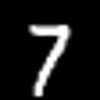

In [16]:
# Select a random image from test set
idx = torch.randint(0, len(test_data), size=(1,))[0]
test_image, test_label = test_data[idx]
test_image = to_pil(test_image)

# View image
test_image.resize((100, 100))

In [17]:
preds = predict(test_image)
print(f'Predicted as {preds[0][0]} with {preds[0][1]}% Confidence')
print('Probabilities:', preds)

Predicted as 7 with 100.0% Confidence
Probabilities: [(7, 100.0), (0, 0.0), (1, 0.0), (2, 0.0), (3, 0.0), (4, 0.0), (5, 0.0), (6, 0.0), (8, 0.0), (9, 0.0)]


## Prepare for Deployment

In [18]:
# Compile model to torchscript using JIT trace
jit_model = torch.jit.trace(model, torch.randn(1, 1, 28, 28), strict=False)

In [19]:
# Save the traced computation graph
jit_model.save('model_jit.pth')